In [1]:
import numpy as np
import torch as tc
import os
import dxchange
from tqdm import tqdm
from scipy.ndimage import rotate as sp_rotate
import xraylib as xlib
import xraylib_np as xlib_np
from functools import partial 
from multiprocessing import Pool
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
if tc.cuda.is_available():  
    dev = "cuda:0" 
    print("running on GPU")
else:  
    dev = "cpu"
    print("running on CPU")

device = tc.device(dev)
print("device = %s" %device)

running on CPU
device = cpu


In [3]:
element_list = np.array(["H", "He",
                         "Li", "Be", "B", "C", "N", "O", "F", "Ne",
                         "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar",
                         "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr",
                         "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe",
                         "Cs", "Ba", "La",
                         "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu",
                                           "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn",
                         "Fr", "Ra", "Ac", 
                         "Th", "Pa", "U", "Np", "Pu", "Am"])



# xraylib uses keV
fl_K = np.array([xlib.KA1_LINE, xlib.KA2_LINE, xlib.KA3_LINE, xlib.KB1_LINE, xlib.KB2_LINE,
                 xlib.KB3_LINE, xlib.KB4_LINE, xlib.KB5_LINE])

fl_L = np.array([xlib.LA1_LINE, xlib.LA2_LINE, xlib.LB1_LINE, xlib.LB2_LINE, xlib.LB3_LINE,
                 xlib.LB4_LINE, xlib.LB5_LINE, xlib.LB6_LINE, xlib.LB7_LINE, xlib.LB9_LINE,
                 xlib.LB10_LINE, xlib.LB15_LINE, xlib.LB17_LINE])

fl_M = np.array([xlib.MA1_LINE, xlib.MA2_LINE, xlib.MB_LINE])

fl_K_str = ["Ka1", "Ka2", "Ka3", "Kb1", "Kb2", "Kb3", "Kb4", "Kb5"]
fl_L_str = ["La1", "La2", "Lb1", "Lb2", "Lb3", "Lb4","Lb5", "Lb6",
             "Lb7", "Lb9", "Lb10", "Lb15", "Lb17"]
fl_Ma_str = ["Ma1", "Ma2", "Mb"]

fl_line_groups = np.array(["K", "L", "M"])

In [4]:
### This rotation function rotates 3d model ###
def rotate(arr, theta):
    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta), 0.0])
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta), 0])
    m = tc.stack([m0, m1]).view(1, 2, 3)
    m = m.repeat([arr.shape[0], 1, 1])
    
    g = F.affine_grid(m, arr.shape)
    q = F.grid_sample(arr, g, padding_mode='border')
    
    return q

torch.Size([5, 5, 5, 5])


Text(0.5, 1.0, 'intensity')

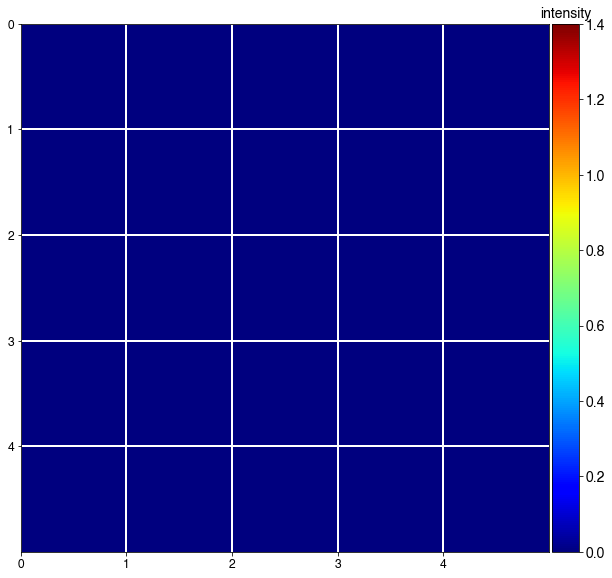

In [5]:
src_path = os.path.join('./data/sample3_pad', 'grid_concentration.npy')
grid_concentration = np.load(src_path).astype(np.float32)  ## dimension: (n_element, model_axis_2 (=smaple_height_n) , model_axis_0, model_axis_1 (the direction of beam propagation))
grid_concentration = tc.from_numpy(grid_concentration).float()
print(grid_concentration.shape) 


## Plot model
fig1 = plt.figure(figsize=(10,10))
gs1 = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1])
fig1_ax1 = fig1.add_subplot(gs1[0,0])
fig1_ax1.set_xticks(np.arange(0, 5, 1))
fig1_ax1.set_yticks(np.arange(0, 5, 1))
fig1_ax1.grid(color='w', linewidth=2)
pos = fig1_ax1.imshow(grid_concentration[3,3], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig1_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig1.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

In [6]:
theta_st = tc.tensor(0).to(dev)
theta_end = tc.tensor(np.pi/4).to(dev)
n_theta =  tc.tensor(3).to(dev)
theta_ls = - tc.linspace(theta_st, theta_end, n_theta).to(dev)
this_theta_idx = tc.tensor(0).to(dev)
sample_size_n = tc.tensor(5).to(dev)
sample_height_n = tc.tensor(5).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
sample_height_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"C": 6, "O": 8, "Si": 14, "Ca": 20, "Fe": 26}
n_element = tc.tensor(len(this_aN_dic))

probe_energy = np.array([20.0])
probe_cts = tc.tensor(1.0E7).to(dev)
n_det = tc.tensor(5).to(dev)
det_size_cm = 0.24
det_from_sample_cm = 1.6
det_ds_spacing_cm = 0.1

element_ls = np.array(list(this_aN_dic.keys()))
aN_ls = np.array(list(this_aN_dic.values()))
probe_attCS_ls = tc.tensor(xlib_np.CS_Total(aN_ls, probe_energy).flatten()).float().to(dev)

### 1: Calculate FL_map_unit

In [7]:
def attenuation_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                sample_size_cm, this_aN_dic, probe_energy, dev):
    
    
    n_element = len(this_aN_dic)
    theta_ls = - np.linspace(theta_st, theta_end, n_theta, dtype=np.float32)
    grid_concentration = tc.tensor(np.load(src_path)).float()
    aN_ls = np.array(list(this_aN_dic.values()))
    probe_attCS_ls = tc.tensor(xlib_np.CS_Total(aN_ls, probe_energy).flatten()).float().to(dev)
    
    att_exponent_acc_map = tc.zeros((len(theta_ls), sample_height_n, sample_size_n, sample_size_n+1), device=dev)
    for i , theta in enumerate(theta_ls):
        theta = tc.tensor(theta,  device=dev)
        concentration_map_rot = rotate(grid_concentration, theta)
        for j in range(n_element):
            lac_single = concentration_map_rot[j] * probe_attCS_ls[j]
            lac_acc = tc.cumsum(lac_single, axis=2)
            lac_acc = tc.cat((tc.zeros((sample_height_n, sample_size_n, 1), device=dev), lac_acc), dim = 2)
            att_exponent_acc = lac_acc * (sample_size_cm / sample_size_n) 
            att_exponent_acc_map[i,:,:,:] += att_exponent_acc

    attenuation_map_flat = tc.exp(-(att_exponent_acc_map[:,:,:,:-1])).view(n_theta, sample_height_n * sample_size_n * sample_size_n)
    transmission = tc.exp(-att_exponent_acc_map[:,:,:,-1]).view(n_theta, sample_height_n * sample_size_n)
    
    return attenuation_map_flat, transmission

/opt/anaconda3/envs/jXRF/lib/python3.8/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/opt/anaconda3/envs/jXRF/lib/python3.8/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Text(0.5, 1.0, 'intensity')

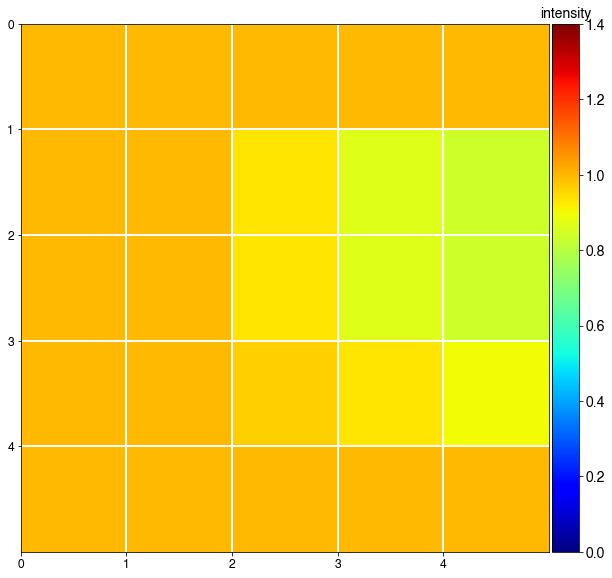

In [8]:
attenuation_map_flat = attenuation_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                                            sample_size_cm, this_aN_dic, probe_energy)[0].view((n_theta, sample_height_n, sample_size_n, sample_size_n))

## Plot transmission map
fig1 = plt.figure(figsize=(10,10))
gs1 = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1])
fig1_ax1 = fig1.add_subplot(gs1[0,0])
fig1_ax1.set_xticks(np.arange(0, 5, 1))
fig1_ax1.set_yticks(np.arange(0, 5, 1))
fig1_ax1.grid(color='w', linewidth=2)
pos = fig1_ax1.imshow(attenuation_map_flat[0,2,:,:], cmap='jet', vmin=0, vmax=1.4, extent=[0, 5, 5, 0], origin='upper')
divider = make_axes_locatable(fig1_ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
cbar = fig1.colorbar(pos, cax=cax, ticks=ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.ax.set_title('intensity', size='14')

In [9]:
def create_XRT_data_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                         sample_size_cm, this_aN_dic, probe_energy, probe_cts, save_path, save_fname, dev):
    """
    Parameters
    ----------
    grid_concentration: string
        the path of the elemental map
        
    theta_st: float
        The initial angle of the sample
        
    theta_end: float
        The final angle of the sample
    
    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels
    
    sample_size_cm: scalar
        sample size in cm
    
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}
        
    probe_energy : ndarray
        This array is an array with only 1 element. The element is the keV energy of the incident beam.
        
    probe_cts : float
        The incident photon counts/s
    
    save_path : string
        The directory of saving the XRT_data

    Returns
    -------
    XRT_data : ndarray
        The dimension of the array is (n_theta, sample_size_n)
        [note: sample_size may not be the same as the input argument because of padding]
    """   
    XRT_data = probe_cts * attenuation_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n,
                sample_size_cm, this_aN_dic, probe_energy, dev)[1]
    
    if os.path.isfile(save_path):
        os.mkdir(save_path)
    else:
        pass
    
    np.save(os.path.join(save_path, save_fname), XRT_data)
    return XRT_data

In [10]:
save_path = './data/sample3_data'
save_fname = 'XRT_sample3'
XRT_data = create_XRT_data_3d(src_path, theta_st, theta_end, n_theta, sample_size_n,
                         sample_size_cm, this_aN_dic, probe_energy, probe_cts, save_path, save_fname

In [11]:
print(XRT_data.shape)

torch.Size([3, 25])


In [12]:
def MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n, sample_size_cm,
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True):
    """   
    Parameters
    ----------
    this_aN_dic: dictionary
        a dictionary of items with key = element symbol (string), and value = atomic number
        e.g. this_aN_dic = {"C":6, "O": 8}

    probe_energy : ndarray
        This array is an array with only 1 element. The element is the keV energy of the incident beam.

    sample_size_n: int scalar
        sample size in number of pixles on one side, assuing a square sample of N x N pixels

    sample_size_cm: scalar
        sample size in cm

    fl_line_groups : ndarray, optional
        DESCRIPTION. The default is np.array(["K", "L", "M"]).

    fl_K : ndarray, optional
        The default is fl_K, an array of sub-lines of K line with the required format by xraylib.

    fl_L : ndarray, optional
        The default is fl_L, an array of sub-lines of L line with the required format by xraylib.

    fl_M : ndarray, optional
        The default is fl_M, an array of sub-lines of M line with the required format by xraylib.

    group_lines : boolean, optional
        Whether treating all K (or L, M) sub-lines as a single line. The default is True.

    Returns
    -------
    FL_all_elements_dic : dictionary
        The dictionary has 3 items. 
        1st item 
        key: "(element_name, Line)"
        value: an ndarray of ndarrays of 2 elements(type: string), [element symbol, line group]
        e.g. [['C', 'K'], ['O', 'K'], ['Si', 'K'], ['Si', 'L']]

        2nd item
        key: "fl_energy"
        value: float, Fluorescence energy in keV for each line of all element

        3rd item: "detected_fl_unit_concentration"
        key: fluorescence yield assuming a unit concentration [1 g/cm^3 ]
    """

    element_ls = np.array(list(this_aN_dic.keys()))
    aN_ls = np.array(list(this_aN_dic.values()))

    n_line_group = len(fl_line_groups)
    FL_all_elements_dic = {"element_Line": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([])}
    voxel_size = sample_size_cm/sample_size_n   

    fl_cs_K = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_K, probe_energy)
    fl_cs_L = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_L, probe_energy)
    fl_cs_M = xlib_np.CS_FluorLine_Kissel_Cascade(aN_ls, fl_M, probe_energy)

    # Remove the extra dimension with only 1 element
    fl_cs_K = np.reshape(fl_cs_K, (fl_cs_K.shape[:-1]))
    fl_cs_L = np.reshape(fl_cs_L, (fl_cs_L.shape[:-1]))
    fl_cs_M = np.reshape(fl_cs_M, (fl_cs_M.shape[:-1]))

    fl_energy_K = xlib_np.LineEnergy(aN_ls, fl_K)
    fl_energy_L = xlib_np.LineEnergy(aN_ls, fl_L)
    fl_energy_M = xlib_np.LineEnergy(aN_ls, fl_M)

    FL_all_elements_dic = {"(element_name, Line)": [], "fl_energy": np.array([]), "detected_fl_unit_concentration": np.array([]),
                           "n_line_group_each_element": np.array([]), "n_lines": None}
    if group_lines == True:
        fl_energy_group = np.zeros((len(element_ls),n_line_group))
        fl_cs_group = np.zeros((len(element_ls),n_line_group))
        for i, element_name in enumerate(element_ls): 

            if np.sum(fl_energy_K[i] != 0):
                fl_energy_group[i,0] = np.average(fl_energy_K[i], weights=fl_cs_K[i]) 
                fl_cs_group[i,0] = np.sum(fl_cs_K[i])
            else:
                fl_energy_group[i,0] = 0
                fl_cs_group[i,0] = 0

            if np.sum(fl_energy_L[i] != 0):
                fl_energy_group[i,1] = np.average(fl_energy_L[i], weights=fl_cs_L[i]) 
                fl_cs_group[i,1] = np.sum(fl_cs_L[i])
            else:
                fl_energy_group[i,1] = 0
                fl_cs_group[i,1] = 0

            if np.sum(fl_energy_M[i] != 0):
                fl_energy_group[i,2] = np.average(fl_energy_M[i], weights=fl_cs_M[i]) 
                fl_cs_group[i,2] = np.sum(fl_cs_M[i])
            else:
                fl_energy_group[i,2] = 0
                fl_cs_group[i,2] = 0

            element_Line = fl_line_groups[fl_energy_group[i]!= 0]
            element_Line = [[element_name, element_Line[j]] for j in range(len(element_Line))]
            for k in range(len(element_Line)):
                FL_all_elements_dic["(element_name, Line)"].append(element_Line[k])     

            Line_energy = fl_energy_group[i][fl_energy_group[i]!=0]
            FL_all_elements_dic["fl_energy"] = np.append(FL_all_elements_dic["fl_energy"], Line_energy)
            fl_unit_con = fl_cs_group[i][fl_energy_group[i]!=0] * voxel_size
            FL_all_elements_dic["detected_fl_unit_concentration"] = np.append(FL_all_elements_dic["detected_fl_unit_concentration"], fl_unit_con)
            FL_all_elements_dic["n_line_group_each_element"] = np.append(FL_all_elements_dic["n_line_group_each_element"], len(fl_unit_con))
            
        FL_all_elements_dic["(element_name, Line)"] = np.array(FL_all_elements_dic["(element_name, Line)"])
    
    FL_all_elements_dic["n_lines"] = len(FL_all_elements_dic["(element_name, Line)"])
    return FL_all_elements_dic


In [13]:
fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                          sample_size_n.numpy(), sample_size_cm.numpy(),
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                          group_lines = True)
print(fl_all_lines_dic)

{'(element_name, Line)': array([['C', 'K'],
       ['O', 'K'],
       ['Si', 'K'],
       ['Si', 'L'],
       ['Ca', 'K'],
       ['Ca', 'L'],
       ['Fe', 'K'],
       ['Fe', 'L']], dtype='<U2'), 'fl_energy': array([0.2774    , 0.5249    , 1.74239384, 0.1456018 , 3.72645881,
       0.33630868, 6.47749773, 0.70737803]), 'detected_fl_unit_concentration': array([5.65302403e-08, 4.60862836e-06, 3.81601182e-04, 3.53124094e-08,
       3.84288186e-03, 3.26019695e-06, 1.58892885e-02, 3.46092357e-04]), 'n_line_group_each_element': array([1., 1., 2., 2., 2.]), 'n_lines': 8}


In [14]:
def generate_fl_signal_from_each_voxel_3d(src_path, theta_st, theta_end, n_theta, sample_size_n, sample_height_n, sample_size_cm, this_aN_dic, probe_energy):

    element_ls = np.array(list(this_aN_dic.keys()))
    theta_ls = - np.linspace(theta_st, theta_end, n_theta)

    grid_concentration = tc.tensor(np.load(src_path)).float()

    fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy,
                              sample_size_n.numpy(), sample_size_cm.numpy(),
                              fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M,
                              group_lines = True)


    fl_map_tot = tc.zeros((n_theta, fl_all_lines_dic["n_lines"], sample_height_n * sample_size_n * sample_size_n))
    for i, theta in enumerate(theta_ls):
        concentration_map_rot = rotate(grid_concentration, tc.tensor(theta, dtype=tc.float32))
        concentration_map_rot_flat = concentration_map_rot.view(len(element_ls), sample_height_n * sample_size_n * sample_size_n)
        line_idx = 0
        for j in range(len(element_ls)):

            ## fetch the generated fl signal at unit concentration for the calculated voxel size
            fl_unit = fl_all_lines_dic["detected_fl_unit_concentration"][line_idx:line_idx + int(fl_all_lines_dic["n_line_group_each_element"][j])]   

            ## FL signal over the current elemental lines for each voxel
            fl_map = [concentration_map_rot_flat[j] * fl_unit_single_line for fl_unit_single_line in fl_unit]
            fl_map = tc.stack(fl_map).float()
            fl_map_tot[i, line_idx:line_idx + fl_map.shape[0],:] = fl_map 
            line_idx = line_idx + len(fl_unit)
            
    return fl_map_tot

### 2: Define the function of line representing the beam path from the FL-emitting voxel to the detectorlets

In [275]:
x_s = 0.5
y_s = 0.5
z_s = 0.5

x_d = 7.5
y_d = 7.5
z_d = 7.5

d_x_ls = tc.tensor([1,2])
d_y_ls = tc.tensor([1,2])
d_z_ls = tc.tensor([1,2])

In [276]:
### This cell solves the intersection of a ray with a plane (x = some constant (d_x)) ###
# The ray using a parametric form with a parameter, t: R(t) = (1-t) * S + t * D 
# The intersecting coordinates: (x, y, z) = (Ix, Iy, Iz) at t=t*

# Define the system of equation AX = b to solve the intersecting, A is with the dimension: (n_batch, 4, 4), b is with the dimension: (n_batch, 4, 1)
# n_batch is the number of planes we put into the equation that we want to solve the intersecting point with the the ray

# def trace_beam_y(x_s, y_s, z_s, x_d, y_d, z_d, d_y_ls):
A = tc.tensor([[1, 0, 0, x_s - x_d],[0, 1, 0, y_s - y_d],[0, 0, 1, z_s - z_d],[0, 1, 0, 0]])
A = A.repeat([len(d_y_ls), 1, 1])

b1 = tc.tensor([[[x_s], [y_s], [z_s]]]).repeat([len(d_y_ls), 1, 1])
b2 = tc.tensor([[[d_y]] for d_y in d_y_ls])
b = tc.cat((b1, b2), dim=1)

X, LU = tc.solve(b, A)
X = X[:,:-1].view(len(d_y_ls), 3)
t = X[:,-1]
#     return X

print(X)
print(X.shape)
print(X.dtype)
print(t)

tensor([[1., 1., 1.],
        [2., 2., 2.]])
torch.Size([2, 3])
torch.float32
tensor([1., 2.])


In [15]:
### This cell solves the intersection of a ray with a plane 
### There're 3 types of plane x = some constant (d_x), y = some constant (d_y) and z = some constant (d_z)
### The correspoinding intersecting points can be solved using trace_beam_x, trace_beam_y, trace_beam_z respectively

# The ray using a parametric form with a parameter, t: R(t) = (1-t) * S + t * D 
# The intersecting coordinates: (x, y, z) = (Ix, Iy, Iz) at t=t*

# Define the system of equation AX = b to solve the intersecting, A is with the dimension: (n_batch, 4, 4), b is with the dimension: (n_batch, 4, 1)
# n_batch is the number of planes we put into the equation that we want to solve the intersecting point with the the ray

def trace_beam_x(x_s, y_s, z_s, x_d, y_d, z_d, d_x_ls):
    if len(d_x_ls) == 0:
        X = np.stack((np.array([]), np.array([]), np.array([])), axis=-1)
    else:
        A = tc.tensor([[1, 0, 0, x_s - x_d],[0, 1, 0, y_s - y_d],[0, 0, 1, z_s - z_d],[1, 0, 0, 0]])
        A = A.repeat([len(d_x_ls), 1, 1])

        b1 = tc.tensor([[[x_s], [y_s], [z_s]]]).repeat([len(d_x_ls), 1, 1])
        b2 = tc.tensor([[[d_x]] for d_x in d_x_ls])
        b = tc.cat((b1, b2), dim=1)

        X, LU = tc.solve(b, A)
        X = np.array(X[:,:-1].view(len(d_x_ls), 3))
#         t = X[:,-1] 
    
    return X

def trace_beam_y(x_s, y_s, z_s, x_d, y_d, z_d, d_y_ls):
    if len(d_y_ls) == 0:
        Y = np.stack((np.array([]), np.array([]), np.array([])), axis=-1)
    else:    
        A = tc.tensor([[1, 0, 0, x_s - x_d],[0, 1, 0, y_s - y_d],[0, 0, 1, z_s - z_d],[0, 1, 0, 0]])
        A = A.repeat([len(d_y_ls), 1, 1])

        b1 = tc.tensor([[[x_s], [y_s], [z_s]]]).repeat([len(d_y_ls), 1, 1])
        b2 = tc.tensor([[[d_y]] for d_y in d_y_ls])
        b = tc.cat((b1, b2), dim=1)

        Y, LU = tc.solve(b, A)
        Y = np.array(Y[:,:-1].view(len(d_y_ls), 3))
#         t = Y[:,-1]
    
    return Y

def trace_beam_z(x_s, y_s, z_s, x_d, y_d, z_d, d_z_ls):
    if len(d_z_ls) == 0:
        Z = np.stack((np.array([]), np.array([]), np.array([])), axis=-1)
    else:
        A = tc.tensor([[1, 0, 0, x_s - x_d],[0, 1, 0, y_s - y_d],[0, 0, 1, z_s - z_d],[0, 0, 1, 0]])
        A = A.repeat([len(d_z_ls), 1, 1])

        b1 = tc.tensor([[[x_s], [y_s], [z_s]]]).repeat([len(d_z_ls), 1, 1])
        b2 = tc.tensor([[[d_z]] for d_z in d_z_ls])
        b = tc.cat((b1, b2), dim=1)

        Z, LU = tc.solve(b, A)
        Z = np.array(Z[:,:-1].view(len(d_z_ls), 3))
#         t = Z[:,-1]
    
    return Z

In [278]:
X = trace_beam_x(x_s, y_s, z_s, x_d, y_d, z_d, d_x_ls)
print(X)
# Y = trace_beam_x(x_s, y_s, z_s, x_d, y_d, z_d, d_y_ls)[0]
# Z = trace_beam_x(x_s, y_s, z_s, x_d, y_d, z_d, d_z_ls)[0]

[[1. 1. 1.]
 [2. 2. 2.]]


In [279]:
sample_x_edge = np.array([sample_size_n])
sample_y_edge = np.array([0, sample_size_n]) 
sample_z_edge = np.array([0, sample_height_n]) 

bd_int = trace_beam_y(0.5, 0.5, 0.5, 806.5, -5.06666667, -57.5, sample_y_edge)
print(bd_int)
print(bd_int[:,0])
print(np.amax(bd_int[:,0]))

print(np.argwhere(bd_int[:,0] == np.max(bd_int[:,0])).flatten())
idx_with_max_x = np.argmax(bd_int[:,0]).flatten()
print(bd_int[idx_with_max_x])

[[ 7.2895210e+01 -1.2915827e-08 -4.7095809e+00]
 [-6.5105688e+02  5.0000000e+00  4.7386227e+01]]
[  72.89521 -651.0569 ]
72.89521
[0]
[[ 7.2895210e+01 -1.2915827e-08 -4.7095809e+00]]


#### P: environment of development

In [17]:
# print(det_size_n)
# print(det_ds_spaing_n)
# print(n_det)


# print(det_axis_2_idx_ls)
# print(det_axis_1_idx_ls)

print(y_d)
print("\n")
print(z_d)
print("\n")
print(yz_mask.reshape((3,3)))
print("\n")

print(y_d_flat)
print(z_d_flat)
print(x_d_flat)
print(det_pos_ls_flat)

[[-57.5   3.   63.5]
 [-57.5   3.   63.5]
 [-57.5   3.   63.5]]


[[-57.5 -57.5 -57.5]
 [  3.    3.    3. ]
 [ 63.5  63.5  63.5]]


[[False  True False]
 [ True  True False]
 [False False False]]


[  3.  -57.5   3. ]
[-57.5   3.    3. ]
[806.5 806.5 806.5]
[[806.5   3.  -57.5]
 [806.5 -57.5   3. ]
 [806.5   3.    3. ]]


In [19]:
### Calculating voxel size in cm
voxel_size_cm = sample_size_cm/sample_size_n

### Calculating the diameter of the XRF detector with 
det_size_n = int(np.ceil(det_size_cm/voxel_size_cm)) 

### Set the desired spacing between detectorlets, and then convert the unit of spacing to the number of the sample voxels
det_ds_spacing_cm = 0.1
det_ds_spacing_n = int(det_ds_spacing_cm/voxel_size_cm)

# Define position of center of the source voxel (x_s, y_s, z_s), note that it's shifted by 0.5 from the voxel idx to represent the loc of center
x_s, y_s, z_s = np.indices((int(sample_size_n), int(sample_size_n), int(sample_height_n))) + 0.5
voxel_pos_ls_flat = np.stack((x_s.flatten(), y_s.flatten(), z_s.flatten()), axis=-1)


### Define the location of the detectorlets, the detector is parallel to the yz-plane
### The x-posision depends on the distance between the sample and the detecor
## x index of the location of the XRF detector
det_axis_0_idx = sample_size_n + np.ceil(det_from_sample_cm/voxel_size_cm) + 0.5

### y, z index of the location of the XRF detector
## Define the center of the detector on yz-plane
det_center_yz = (int(sample_size_n)/2, int(sample_size_n)/2)

## Define the y and z loc(namely the loc along axis 1 and axis 2) of the detectorlets. The y and z loc are confined to be within a circle on the yz plane
det_axis_1_idx_ls = np.linspace(np.ceil(int(sample_size_n)/2 - int(det_size_n)/2), 
                                  np.ceil(int(sample_size_n)/2 + int(det_size_n)/2), int(np.ceil(det_size_n/det_ds_spacing_n))) + 0.5

## y, z location of the XRF detector
det_axis_2_idx_ls = np.linspace(np.ceil(int(sample_height_n)/2 - int(det_size_n)/2), 
                                  np.ceil(int(sample_height_n)/2 + int(det_size_n)/2), int(np.ceil(det_size_n/det_ds_spacing_n))) + 0.5

## Create the meshgrid of y and z coordinates and keep only the coordinates within the detector circle
y_d, z_d = np.meshgrid(det_axis_1_idx_ls, det_axis_2_idx_ls)
yz_mask = ((y_d - det_center_yz[0])**2 + (z_d - det_center_yz[1])**2 <= (det_size_n/2)**2).flatten()
y_d_flat, z_d_flat = y_d.flatten()[yz_mask], z_d.flatten()[yz_mask]

## The number of x posision needed to fill into the coodinates depends on the number of the y(or z) coodinates within the circle of detector
x_d_flat = np.full((y_d_flat.shape), det_axis_0_idx)

##
det_pos_ls_flat = np.stack((x_d_flat, y_d_flat, z_d_flat), axis=-1)
# det_pos_ls_flat_ds = det_pos_ls_flat[::det_ds_spaing_n]
n_det = len(det_pos_ls_flat)
# print(n_det)
# print(det_pos_ls_flat_ds[0])
# print(voxel_pos_ls_flat[0])

# with np.printoptions(threshold=np.inf):
#     print(det_pos_ls_flat_ds)
    
## define sample edges: 
## sample_x_edge is the edge that is closer to the XRF detector
## sample_y_edge has two components representing the left and the right edge
sample_x_edge = np.array([sample_size_n])
sample_y_edge = np.array([0, sample_size_n]) 
sample_z_edge = np.array([0, sample_height_n]) 

P = np.zeros((n_det, sample_size_n * sample_size_n * sample_height_n, sample_size_n * sample_size_n * sample_height_n), dtype=np.float32)


for i,  det_pos in enumerate(det_pos_ls_flat):
    for j, v in enumerate(voxel_pos_ls_flat):
#         print("i, j = %d, %d" %(i, j)) 
        
        # Solving the intersection of the ray with the sample boundary along axis-0
        bdx_int = trace_beam_x(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_x_edge)[0] # pick the 0th component just because the coordinate is doubly braced
#         print(bdx_int)
        
        # Solving the intersection of the ray with the sample boundaries along axis-1 and axis-2, we will get 2 solutions for each axis since there're 2 bdry plane on each axis
        # The desired intersecting point is within the segment(voxel - detectorlet) which is always the one with the larger x coordinate
        bdy_int = trace_beam_y(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_y_edge)
        bdy_int = bdy_int[np.argmax(bdy_int[:,0])]
#         print(bdy_int)
        
        bdz_int = trace_beam_z(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_z_edge)
        bdz_int = bdz_int[np.argmax(bdz_int[:,0])]
#         print(bdz_int)
        
        # Pick the intersecting point that first hit the boundary plan. This point is with the least x value among the 3 intersections.
        bd_int_ls = np.array([bdx_int, bdy_int, bdz_int])
#         print(bd_int_ls)
        bd_int = bd_int_ls[np.argmin(bd_int_ls[:,0])]
#         print(bd_int)
#         print(v)
        
        
           
        # when the beam intersects with a voxel, it either intersects with the x or y or z boundary plane of the voxel
        # find the x,y,z-value of the voxel boundary except the ones on the sample edge
        x_edge_ls = np.linspace(np.ceil(bd_int[0])-1, np.ceil(v[0]), int(np.abs(np.ceil(bd_int[0]) - np.ceil(v[0]))))
        y_edge_ls = np.linspace(np.ceil(bd_int[1])-1, np.ceil(v[1]), int(np.abs(np.ceil(bd_int[1]) - np.ceil(v[1])))) 
        z_edge_ls = np.linspace(np.ceil(bd_int[2])-1, np.ceil(v[2]), int(np.abs(np.ceil(bd_int[2]) - np.ceil(v[2]))))
        x_edge_int_ls = trace_beam_x(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], x_edge_ls)
        y_edge_int_ls = trace_beam_y(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], y_edge_ls)
        z_edge_int_ls = trace_beam_z(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], z_edge_ls)

        # Collect all intersecting points and sort all intersections using the x coordinate
        int_ls = np.concatenate((x_edge_int_ls, y_edge_int_ls, z_edge_int_ls, np.array([bd_int])))     
        int_ls = int_ls[np.argsort(int_ls[:,0])]
#         print(int_ls)

        # calculate the intersecting length in the intersecting voxels
        int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2)
        # just in case that we count some intersections twice, delete the duplicates
        idx_duplicate = np.array(np.where(int_length==0)).flatten()
        int_ls = np.delete(int_ls, idx_duplicate, 0)
        int_length = np.delete(int_length, idx_duplicate) 

        # determine the indices of the intersecting voxels according to the intersecting x,y,z-coordinates
        int_ls_shift = np.zeros((int_ls.shape))
        int_ls_shift[1:] = int_ls[:-1]
        int_idx = np.floor((int_ls + int_ls_shift)/2)[1:]
        int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'), int_idx[:,2].astype('int'))
#         print(int_idx)

        # construct the int_length_map, and scale the intersecting length based on the voxel size
        int_length_map = np.zeros((sample_size_n, sample_size_n, sample_height_n))
        int_length_map[int_idx] = int_length * voxel_size_cm.item()

        P[i, j, :] = np.asarray(int_length_map.flatten(), dtype=np.float32)
#     return P

#### Generate P using a function

In [20]:
def intersecting_length_fl_detectorlet_3d(det_size_cm=None, det_from_sample_cm=None, det_ds_spacing_cm=None, sample_size_n=None, sample_size_cm=None, sample_height_n=None):
    ### Calculating voxel size in cm
    voxel_size_cm = sample_size_cm/sample_size_n

    ### Calculating the diameter of the XRF detector with 
    det_size_n = int(np.ceil(det_size_cm/voxel_size_cm)) 

    ### Set the desired spacing between detectorlets, and then convert the unit of spacing to the number of the sample voxels
#     det_ds_spacing_cm = 1
    det_ds_spacing_n = int(det_ds_spacing_cm/voxel_size_cm)

    # Define position of center of the source voxel (x_s, y_s, z_s), note that it's shifted by 0.5 from the voxel idx to represent the loc of center
    x_s, y_s, z_s = np.indices((int(sample_size_n), int(sample_size_n), int(sample_height_n))) + 0.5
    voxel_pos_ls_flat = np.stack((x_s.flatten(), y_s.flatten(), z_s.flatten()), axis=-1)


    ### Define the location of the detectorlets, the detector is parallel to the yz-plane
    ### The x-posision depends on the distance between the sample and the detecor
    ## x index of the location of the XRF detector
    det_axis_0_idx = sample_size_n + np.ceil(det_from_sample_cm/voxel_size_cm) + 0.5

    ### y, z index of the location of the XRF detector
    ## Define the center of the detector on yz-plane
    det_center_yz = (int(sample_size_n)/2, int(sample_size_n)/2)

    ## Define the y and z loc(namely the loc along axis 1 and axis 2) of the detectorlets. The y and z loc are confined to be within a circle on the yz plane
    det_axis_1_idx_ls = np.linspace(np.ceil(int(sample_size_n)/2 - int(det_size_n)/2), 
                                      np.ceil(int(sample_size_n)/2 + int(det_size_n)/2), int(np.ceil(det_size_n/det_ds_spacing_n))) + 0.5

    ## y, z location of the XRF detector
    det_axis_2_idx_ls = np.linspace(np.ceil(int(sample_height_n)/2 - int(det_size_n)/2), 
                                      np.ceil(int(sample_height_n)/2 + int(det_size_n)/2), int(np.ceil(det_size_n/det_ds_spacing_n))) + 0.5

    ## Create the meshgrid of y and z coordinates and keep only the coordinates within the detector circle
    y_d, z_d = np.meshgrid(det_axis_1_idx_ls, det_axis_2_idx_ls)
    yz_mask = ((y_d - det_center_yz[0])**2 + (z_d - det_center_yz[1])**2 <= (det_size_n/2)**2).flatten()
    y_d_flat, z_d_flat = y_d.flatten()[yz_mask], z_d.flatten()[yz_mask]

    ## The number of x posision needed to fill into the coodinates depends on the number of the y(or z) coodinates within the circle of detector
    x_d_flat = np.full((y_d_flat.shape), det_axis_0_idx)

    ##
    det_pos_ls_flat = np.stack((x_d_flat, y_d_flat, z_d_flat), axis=-1)
    n_det = len(det_pos_ls_flat)
    
    # print(n_det)
    # print(det_pos_ls_flat_ds[0])
    # print(voxel_pos_ls_flat[0])

    # with np.printoptions(threshold=np.inf):
    #     print(det_pos_ls_flat_ds)

    ## define sample edges: 
    ## sample_x_edge is the edge that is closer to the XRF detector
    ## sample_y_edge has two components representing the left and the right edge
    sample_x_edge = np.array([sample_size_n])
    sample_y_edge = np.array([0, sample_size_n]) 
    sample_z_edge = np.array([0, sample_height_n]) 

    P = np.zeros((n_det, sample_size_n * sample_size_n * sample_height_n, sample_size_n * sample_size_n * sample_height_n), dtype=np.float32)


    for i,  det_pos in enumerate(det_pos_ls_flat):
        for j, v in enumerate(voxel_pos_ls_flat):
    #         print("i, j = %d, %d" %(i, j)) 

            # Solving the intersection of the ray with the sample boundary along axis-0
            bdx_int = trace_beam_x(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_x_edge)[0] # pick the 0th component just because the coordinate is doubly braced
    #         print(bdx_int)

            # Solving the intersection of the ray with the sample boundaries along axis-1 and axis-2, we will get 2 solutions for each axis since there're 2 bdry plane on each axis
            # The desired intersecting point is within the segment(voxel - detectorlet) which is always the one with the larger x coordinate
            bdy_int = trace_beam_y(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_y_edge)
            bdy_int = bdy_int[np.argmax(bdy_int[:,0])]
    #         print(bdy_int)

            bdz_int = trace_beam_z(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], sample_z_edge)
            bdz_int = bdz_int[np.argmax(bdz_int[:,0])]
    #         print(bdz_int)

            # Pick the intersecting point that first hit the boundary plan. This point is with the least x value among the 3 intersections.
            bd_int_ls = np.array([bdx_int, bdy_int, bdz_int])
    #         print(bd_int_ls)
            bd_int = bd_int_ls[np.argmin(bd_int_ls[:,0])]
    #         print(bd_int)
    #         print(v)



            # when the beam intersects with a voxel, it either intersects with the x or y or z boundary plane of the voxel
            # find the x,y,z-value of the voxel boundary except the ones on the sample edge
            x_edge_ls = np.linspace(np.ceil(bd_int[0])-1, np.ceil(v[0]), int(np.abs(np.ceil(bd_int[0]) - np.ceil(v[0]))))
            y_edge_ls = np.linspace(np.ceil(bd_int[1])-1, np.ceil(v[1]), int(np.abs(np.ceil(bd_int[1]) - np.ceil(v[1])))) 
            z_edge_ls = np.linspace(np.ceil(bd_int[2])-1, np.ceil(v[2]), int(np.abs(np.ceil(bd_int[2]) - np.ceil(v[2]))))
            x_edge_int_ls = trace_beam_x(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], x_edge_ls)
            y_edge_int_ls = trace_beam_y(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], y_edge_ls)
            z_edge_int_ls = trace_beam_z(v[0], v[1], v[2], det_pos[0], det_pos[1], det_pos[2], z_edge_ls)

            # Collect all intersecting points and sort all intersections using the x coordinate
            int_ls = np.concatenate((x_edge_int_ls, y_edge_int_ls, z_edge_int_ls, np.array([bd_int])))     
            int_ls = int_ls[np.argsort(int_ls[:,0])]
    #         print(int_ls)

            # calculate the intersecting length in the intersecting voxels
            int_length = np.sqrt(np.diff(int_ls[:,0])**2 + np.diff(int_ls[:,1])**2)
            # just in case that we count some intersections twice, delete the duplicates
            idx_duplicate = np.array(np.where(int_length==0)).flatten()
            int_ls = np.delete(int_ls, idx_duplicate, 0)
            int_length = np.delete(int_length, idx_duplicate) 

            # determine the indices of the intersecting voxels according to the intersecting x,y,z-coordinates
            int_ls_shift = np.zeros((int_ls.shape))
            int_ls_shift[1:] = int_ls[:-1]
            int_idx = np.floor((int_ls + int_ls_shift)/2)[1:]
            int_idx = (int_idx[:,0].astype('int'), int_idx[:,1].astype('int'), int_idx[:,2].astype('int'))
    #         print(int_idx)

            # construct the int_length_map, and scale the intersecting length based on the voxel size
            int_length_map = np.zeros((sample_size_n, sample_size_n, sample_height_n))
            int_length_map[int_idx] = int_length * voxel_size_cm.item()

            P[i, j, :] = int_length_map.flatten().astype(np.float32)
    return n_det, P


In [21]:
P_all = intersecting_length_fl_detectorlet_3d(det_size_cm, det_from_sample_cm, det_ds_spacing_cm, sample_size_n, sample_size_cm, sample_height_n)

In [22]:
print(P_all[0])

3


### 3: Calculate SA in 3d case (the map of attenuation ratio due to self-absorption of the FL signal):
#### SA function

In [122]:
theta = theta_ls[this_theta_idx]
n_det = P_all[0]
P = tc.from_numpy(P_all[1])
print(P.shape)

torch.Size([23, 125, 125])


In [182]:
def self_absorption_att_ratio_single_theta_3d(src_path, det_size_cm, det_from_sample_cm, det_ds_spacing_cm, sample_size_n, sample_size_cm, sample_height_n, 
                                             this_aN_dic, probe_energy, dev, theta):
    
    fl_all_lines_dic = MakeFLlinesDictionary(this_aN_dic, probe_energy, sample_size_n.numpy(), sample_size_cm.numpy(),
                          fl_line_groups = np.array(["K", "L", "M"]), fl_K = fl_K, fl_L = fl_L, fl_M = fl_M, group_lines = True)
    
    P_all = intersecting_length_fl_detectorlet_3d(det_size_cm, det_from_sample_cm, det_ds_spacing_cm, sample_size_n, sample_size_cm, sample_height_n)
    n_det = P_all[0]
    P = tc.from_numpy(P_all[1])
    
    n_lines = fl_all_lines_dic["n_lines"]
    aN_ls = np.array(list(this_aN_dic.values()))
    element_ls = np.array(list(this_aN_dic.keys()))    
    grid_concentration = tc.from_numpy(np.load(src_path)).float()
    n_element = len(this_aN_dic)

    # generate an arrary of total attenuation cross section with the dimension: (n_element, n_elemental_lines)
    # The component in the array represents the total attenuation cross section at some line energy in some element (with unitary concentration)
    FL_line_attCS_ls = xlib_np.CS_Total(aN_ls, fl_all_lines_dic["fl_energy"])


    concentration_map_rot = rotate(grid_concentration, theta)
    concentration_map_rot_flat = concentration_map_rot.view(n_element, sample_height_n * sample_size_n * sample_size_n)
    SA_theta = tc.zeros((n_lines, sample_height_n * sample_size_n * sample_size_n), device=dev)

    for j in tqdm(range(sample_height_n * sample_size_n * sample_size_n)):       
        att_exponent_elemental_sum_temp = tc.zeros((n_element, n_det, n_lines), device=dev)
        for k in range(n_element):

            ## linear attenuation coefficient for each fl-line at each voxel: (sample_size_n * sample_size_n * sample_height_n, n_lines)
            lac = tc.stack([FL_line_attCS * concentration_map_rot_flat[k] for FL_line_attCS in FL_line_attCS_ls[k]], dim=1)
    #         print(lac.shape)

            ## att_exponent = [(intersecting_length_path1 * lac), (intersecting_length_path2 * lac), ..., (intersecting_length_path5 * lac)]:
            ## att_exponent (for each fl-line, at each_voxel, for each beam path): (self.n_det, sample_size * sample_size, self.n_lines)
            att_exponent = tc.stack([tc.unsqueeze(P[m,j,:], dim=1) * lac for m in range(n_det)])
    #         print(att_exponent.shape)


            ## att_exponent summing over voxels (for each line, for each beam path): (self.n_det, n_elemental_line)
            att_exponent_voxel_sum = tc.sum(att_exponent, axis=1)

            ## filling att_exponent_voxel_sum to att_exponent_elemental_sum for each element
            att_exponent_elemental_sum_temp[k, :, :] = att_exponent_voxel_sum

        ## summing over the attenation exponent contributed by each element
        att_exponent_elemental_sum =  tc.sum(att_exponent_elemental_sum_temp, axis=0)  

        ## calculate the attenuation caused by all elements
        att = tc.exp(- att_exponent_elemental_sum)

        ## calculate the attenuation averaged all paths
        att_path_ave = tc.mean(att, axis=0)
        SA_theta[:,j] = att_path_ave
    # SA_theta = np.array(SA_theta)
        
    return SA_theta

In [183]:
SA_theta = self_absorption_att_ratio_single_theta_3d(src_path, n_det, det_size_cm, det_from_sample_cm, sample_size_n, sample_size_cm, sample_height_n, 
                                             this_aN_dic, probe_energy, theta)

print(SA_theta.shape)

100%|██████████| 125/125 [00:00<00:00, 340.19it/s]

torch.Size([8, 125])


In [184]:
def self_absorption_att_ratio_3d(n_thread, theta_st, theta_end, n_theta, src_path, det_size_cm, det_from_sample_cm, det_ds_spacing_cm, sample_size_n, sample_size_cm, 
                                       sample_height_n, this_aN_dic, probe_energy, dev):
    
    
    pfunc = partial(self_absorption_att_ratio_single_theta_3d, src_path, det_size_cm, det_from_sample_cm, det_ds_spacing_cm, sample_size_n, sample_size_cm,
                    sample_height_n, this_aN_dic, probe_energy, dev)
    theta_ls = - tc.linspace(theta_st, theta_end, n_theta).to(dev)
    with Pool(n_thread) as p:
        SA = tc.stack(p.map(pfunc, theta_ls))   
    # SA = tc.from_numpy(SA)
    return SA

In [185]:
def create_XRF_data_3d(n_thread, theta_st, theta_end, n_theta, src_path, det_size_cm, det_from_sample_cm, det_ds_spacing_cm, sample_size_n,
                    sample_size_cm, sample_height_n, this_aN_dic, probe_cts, probe_energy, save_path, save_fname, dev):      
    
    # (n_theta, sample_size_n * sample_size_n)
    probe_before_attenuation_flat = probe_cts * tc.ones((sample_size_n * sample_size_n * sample_height_n))
    att_ratio_map_flat = attenuation_3d(src_path, theta_st, theta_end, n_theta, sample_height_n, sample_size_n, sample_size_cm, this_aN_dic, probe_energy, dev)[0]
    probe_after_attenuation_flat = probe_before_attenuation_flat * att_ratio_map_flat
    
    #(n_theta, sample_size_n * sample_size_n * sample_height_n, n_elemental_line)
    fl_ratio_map_tot = generate_fl_signal_from_each_voxel_3d(src_path, theta_st, theta_end, n_theta, sample_size_n, sample_height_n, sample_size_cm, this_aN_dic, probe_energy)
    
    
    #elemental lines in cts generated at each voxel position (before going through self-absorption). dimension: (n_theta, sample_size * sample_size * sample_height, n_elemental_line)

    fl_signal_wo_SA = tc.unsqueeze(probe_after_attenuation_flat, dim=1) * fl_ratio_map_tot
    
    print("Start calculating signal attenuation after self-absorption ...")
    #Calculate signal attenuation after self-absorption. dimension: (n_theta, sample_size * sample_size * sample_height, n_elemental_line)
    SA_att_ratio = self_absorption_att_ratio_3d(n_thread, theta_st, theta_end, n_theta, src_path, det_size_cm, det_from_sample_cm, det_ds_spacing_cm,
                                                sample_size_n, sample_size_cm, sample_height_n, this_aN_dic, probe_energy, dev)

       
    #calculate fluorescence after self-absorption. dimension: (n_theta, len(smaple.shape[0]), n_elemental_line)
    fl_signal_SA = fl_signal_wo_SA * SA_att_ratio
    
      
    fl_signal_SA = fl_signal_SA.view(n_theta, -1, sample_size_n, sample_size_n, sample_height_n)
    fl_signal_SA = tc.sum(fl_signal_SA, axis=3)
    
    np.save(os.path.join(save_path, save_fname), fl_signal_SA)
    return fl_signal_SA